In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
sys.path.append('../../../../')  # 'class_func.py' dosyası üst klasörde olduğu için onu path'e eklendi

import class_func as cf # 'class_func.py' dosyasını import edildi
import numpy as np # numpy kütüphanesini import edildi
from matplotlib import pyplot as plt

# Creating OC_model object
func = cf.OC_model() 

# Defining parameters
lin = cf.Lin() # OC model nesnesine eklenmek için lin model bileşeni oluşturuldu
lin.dP = cf.Parameter(0, min=-1e-8, max=1e-8, std=1e-9)
lin.dT = cf.Parameter(1e-5, min=-1e-3, max=1e-3, std=1e-2)
quad = cf.Quad() # OC model nesnesine eklenmek için quad model bileşeni oluşturuldu
quad.Q = cf.Parameter(0, min=-1E-9, max=1e-9, std=1e-11)
lite = cf.LiTE() # OC model nesnesine eklenmek için LiTE model bileşeni oluşturuldu
lite.amp = cf.Parameter(4.4e-5, min=0, max=1e-3, std=.003)
lite.e = cf.Parameter(0, min=0, max=.8, std=.1, vary=False)
lite.P_LiTE = cf.Parameter(15, unit="year", min=5, max=20,std=1)
lite.T_LiTE = cf.Parameter(32000, min=15000, max=50000 , std=100000)
lite.omega = cf.Parameter(65, min=-190, max=200, std=100)
lite.name = "LiTE1"

# Adding model components to model
func.add_model_component(quad)
func.add_model_component(lin)
func.add_model_component(lite) 

In [2]:
# Reading Data
df = pd.read_excel("../../DD_CrB_data.xlsx")
df['Type'] = df['Type'].apply(lambda x: 0 if x == 'p' else 1)
data = cf.OC_data()
data.Mintimes = df["BJD Min"].to_numpy()
data.Mintypes = df["Type"].to_numpy()
data.Errors = df["Err"].to_numpy()
data.Data_group = df["obs type"]
data.object_name = "DD_CrB"
data.Ref_mintime = 2455611.92657 #Wolf M. 2021
data.Ref_period = 0.161770446

# Filling Errors
data = data.fill_errors(method="median")
data.fill_weights()

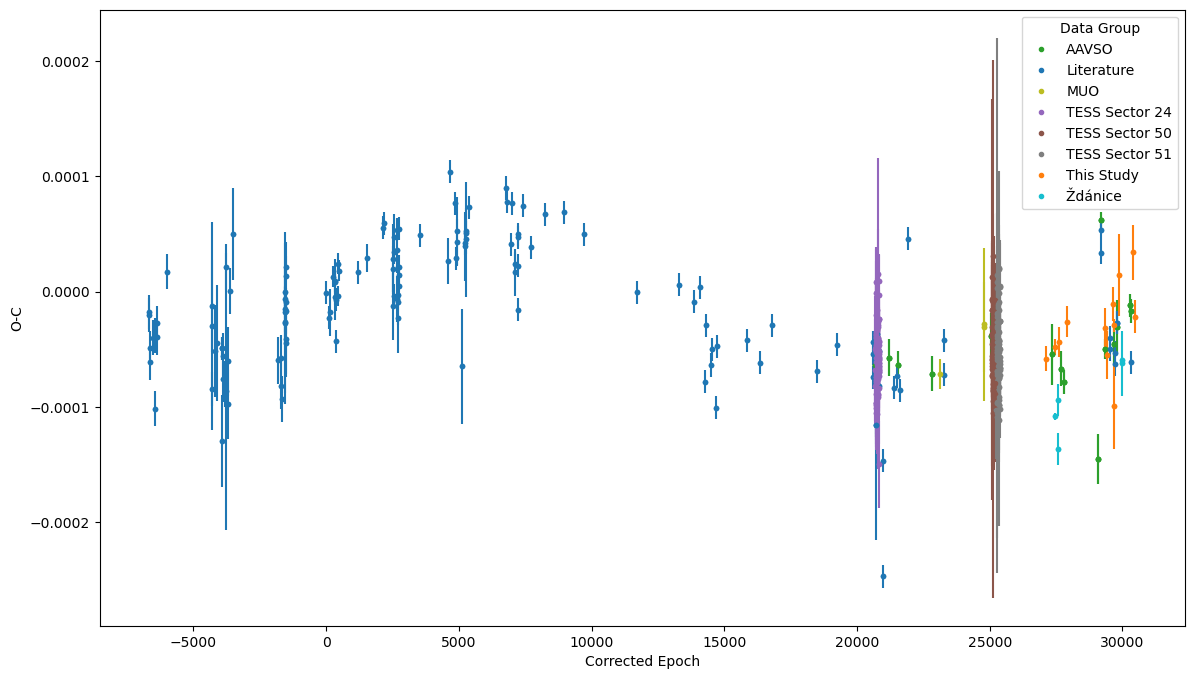

In [3]:
# Plotting data
data.plot_OC()

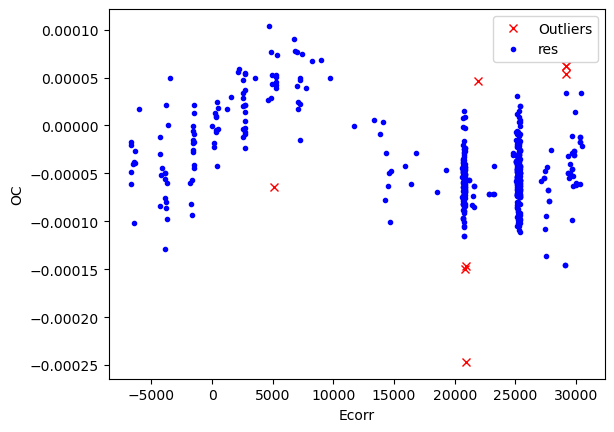

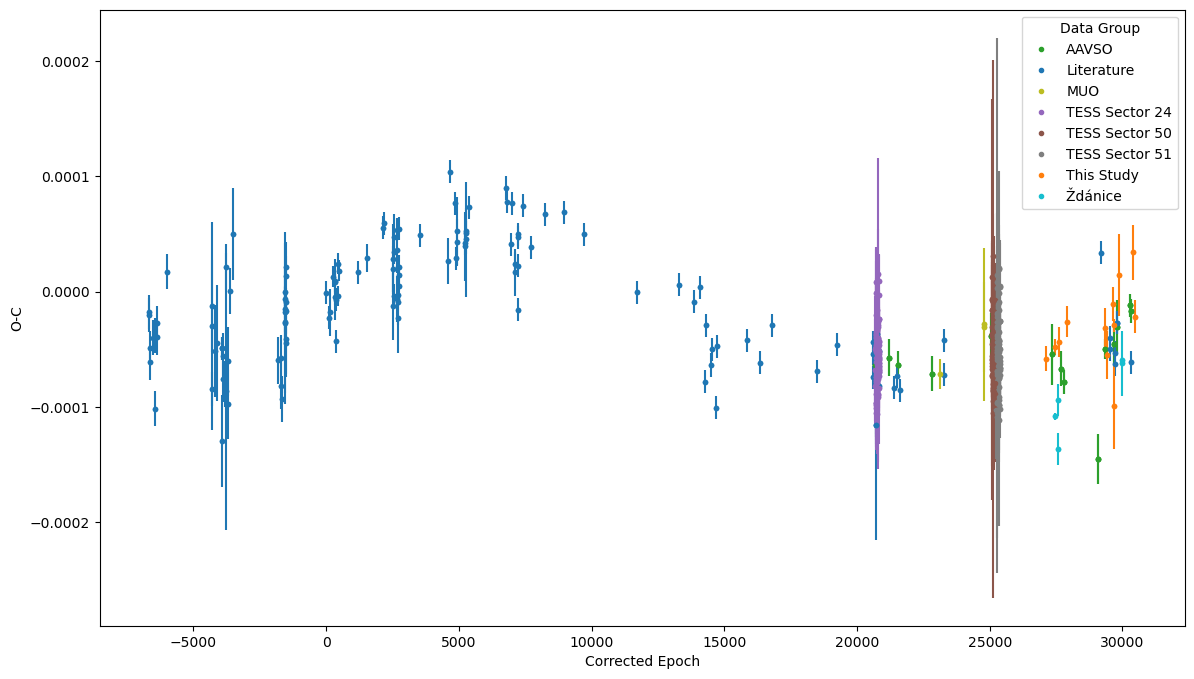

In [4]:
#Defining Outliers and removing them
outliers = data.sigma_outliers(treshold=3, plot=True, additional_method="moving_window", additional_params={"window_rate":.1, "window_step_rate":.03})
data = data.remove_outliers(outliers)
data.plot_OC()

In [5]:
# Binning Tess data
data = data.binning(start_x=24000, end_x=26000, group="TESS Sector 50", bin_count=15, smart_bin=True, binned_group_name="TESS Sector 50")
data = data.binning(start_x=24000, end_x=26000, group="TESS Sector 51", bin_count=15, smart_bin=True, binned_group_name="TESS Sector 51")
data = data.binning(start_x=20000, end_x=21000, group="TESS Sector 24", bin_count=15, smart_bin=True, binned_group_name="TESS Sector 24")

102
89
107


In [6]:
# Removing ± 3 Sigma Errors
max_error = np.mean(data.Errors) + 3 * np.std(data.Errors)
data = data.filter_data_range(dtype="Errors", max_value=max_error, plot=True)
max_error = np.mean(data.Errors) + 3 * np.std(data.Errors)
data = data.filter_data_range(dtype="Errors", max_value=max_error, plot=True)
max_error = np.mean(data.Errors) + 3 * np.std(data.Errors)
data = data.filter_data_range(dtype="Errors", max_value=max_error, plot=True)
max_error = np.mean(data.Errors) + 3 * np.std(data.Errors)
data = data.filter_data_range(dtype="Errors", max_value=max_error, plot=True)

In [7]:
# Creating fit object
fit = cf.fit(data=data, model=func)

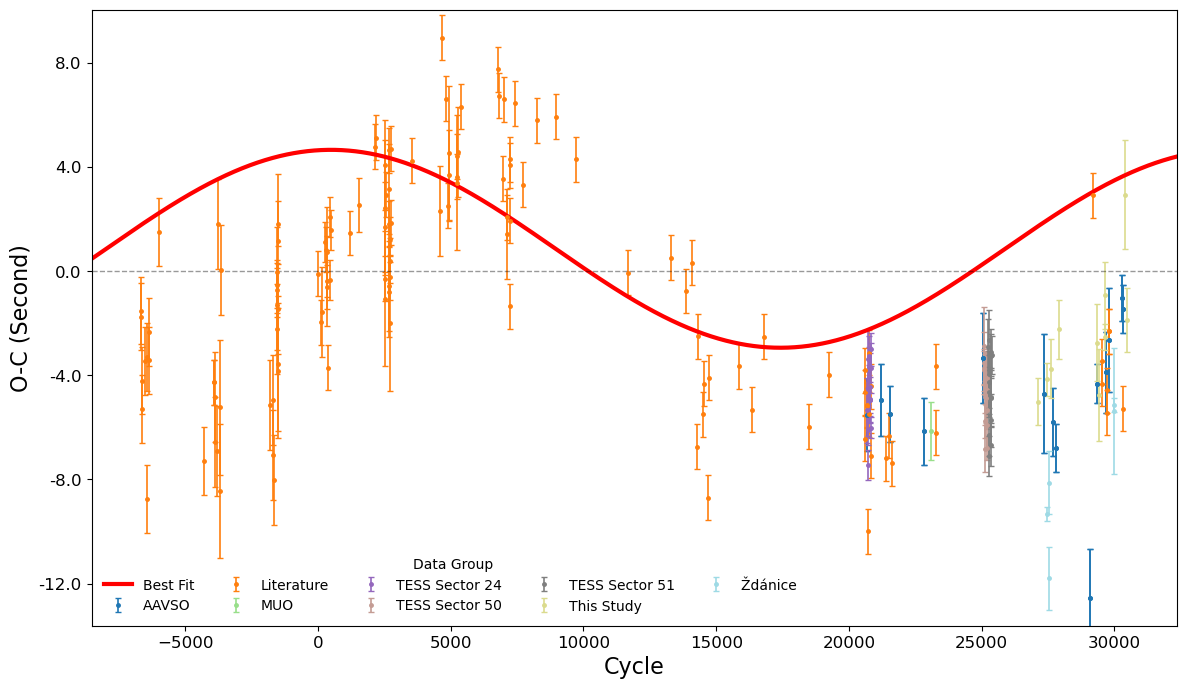

In [8]:
# Fitting model and data together, As you can see current model is bad
fit.plot()

In [9]:
# Fitting and creating emcee sample
result = fit.fit_model(method='leastsq')

In [10]:
result

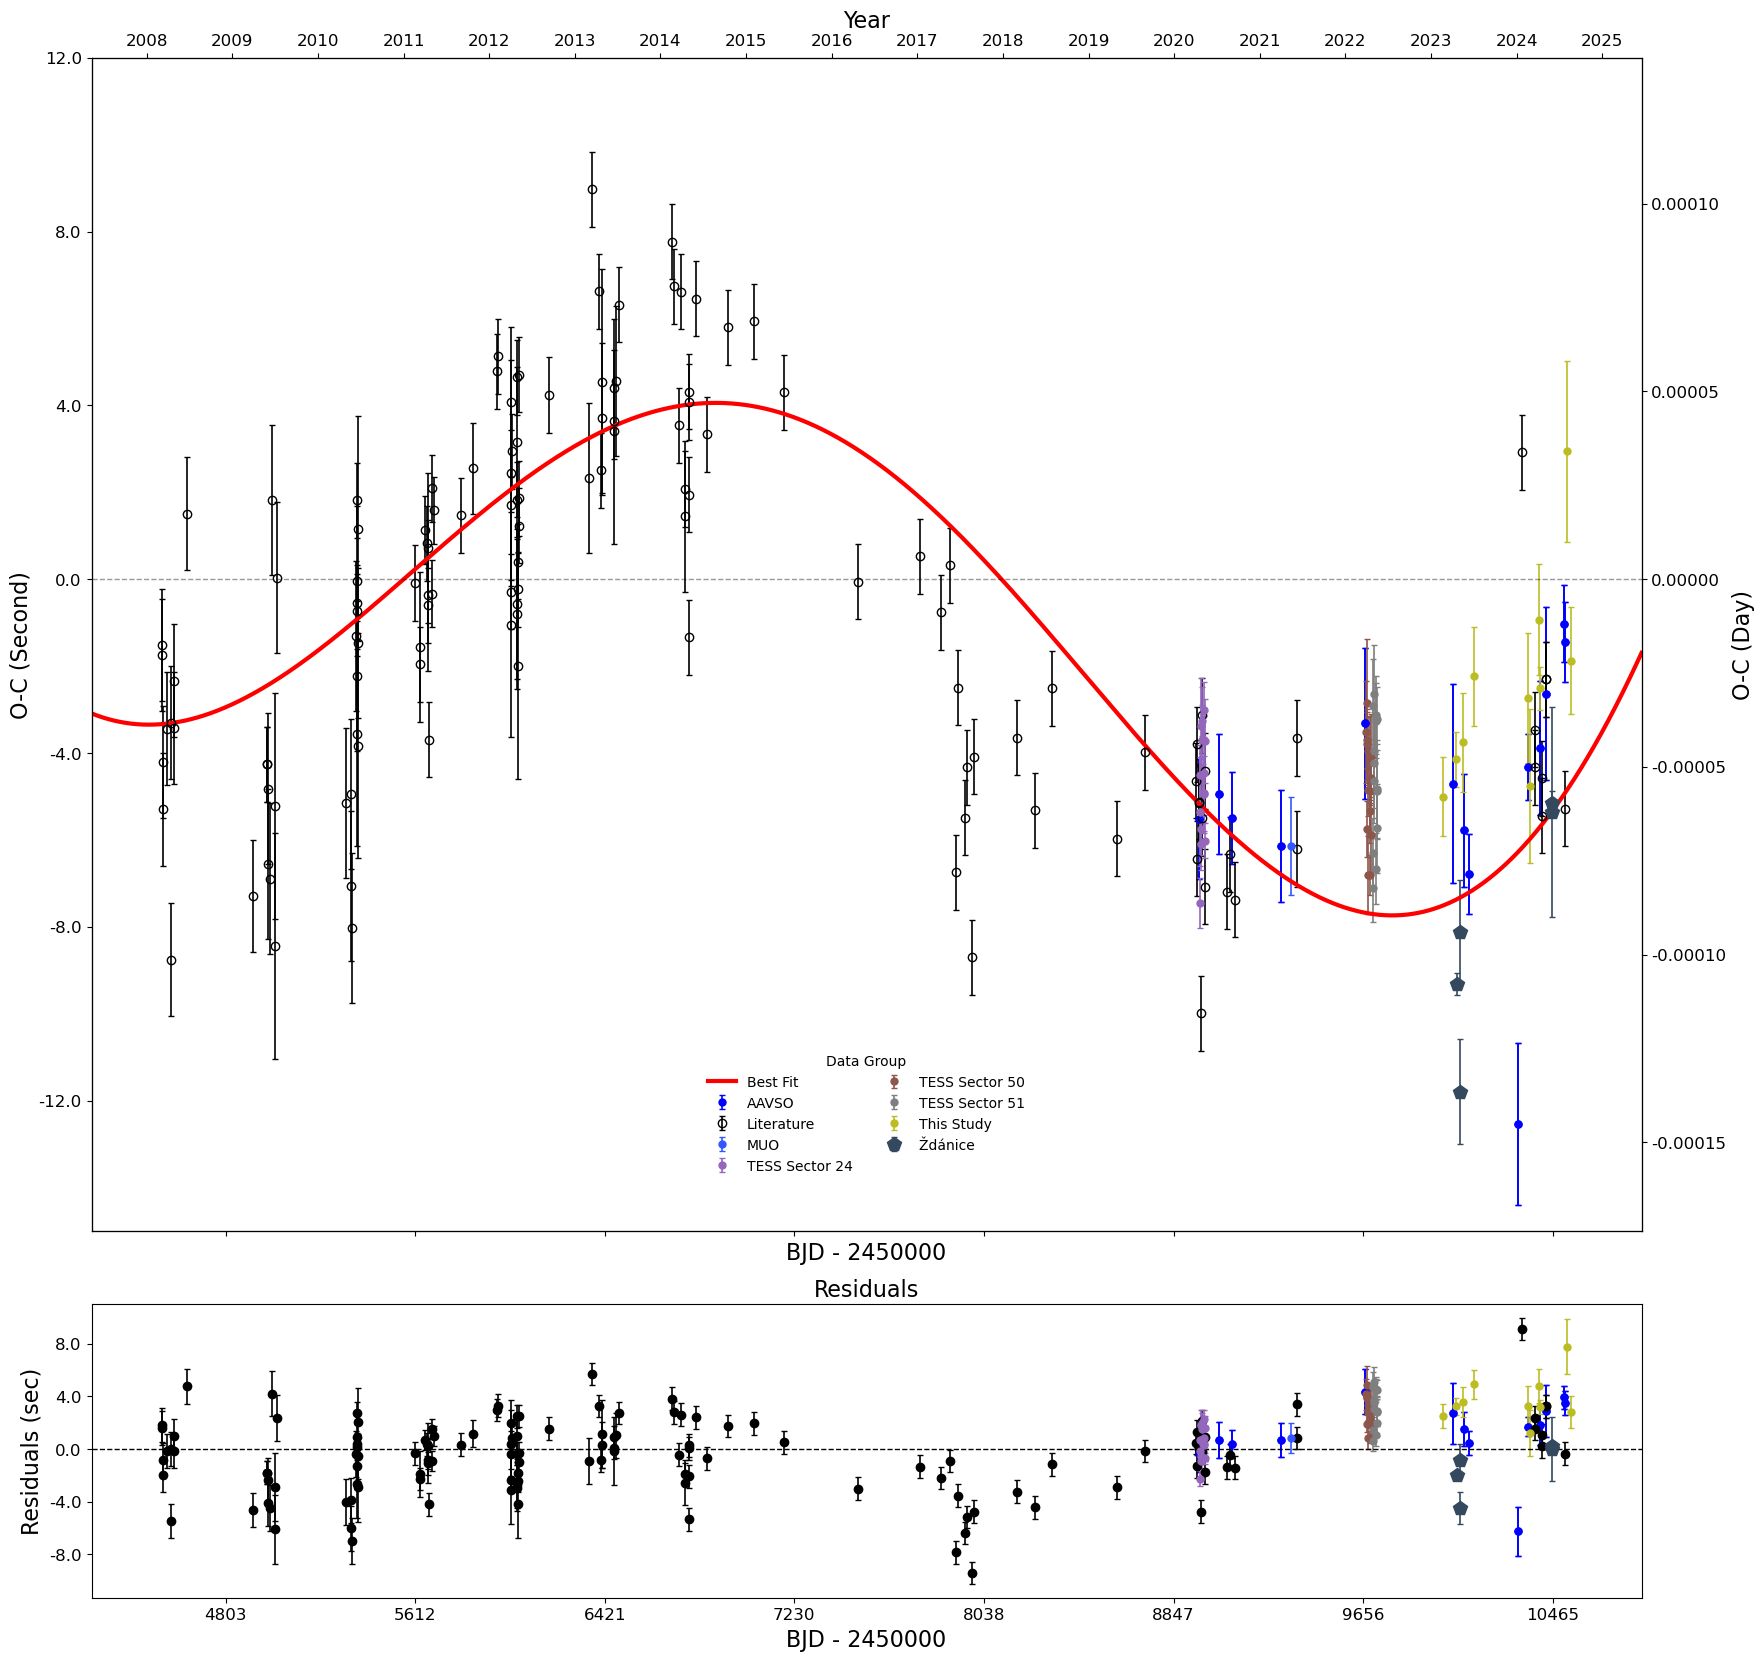

In [11]:
fig = fit.plot(show=True, 
                color_palette="tab10", #color palette https://matplotlib.org/stable/users/explain/colors/colormaps.html for more info
                x_axis_bot="BJD", 
                x_axis_top="year", 
                y_axis_left="second", 
                y_axis_right="day", #None if not needed 
                extend_graph_factor=0.05, #graph extention to x-axis related to whole graph
                graph_size=(20, 20), 
                label_size=16, 
                tick_size=12,
                y_lim=(-15,12),
                legend_position=(.5,.1),
                legend_size=10,
                legend_shape=(2,6),
                res_plot=True,
                group_colors = [
                    "b", # you can recolor groups
                    "0",  
                    "#3357FF",  
                    None, # if None it becomes the next color of given color palette 
                    None,  
                    None, 
                    None,  
                    "#34495E" 
                ],
                group_shapes = [
                    None,   # None is for "."
                    "o",   # circle.
                    None,
                    None,
                    None,
                    None,
                    None,
                    "p"    # Pentagon.
                ],
                group_sizes = [
                    10, 
                    6, 
                    10,  
                    10,
                    10, 
                    10, 
                    10,  
                    10,   
                ],
                res_hspace=0.1
                )

In [12]:
# Get params
for mc in fit.fitted_model.model_components:
    print(mc.params)

{'Q': 4.46295155545184e-13 Unitless}
{'dP': -9.391602747939232e-09 day, 'dT': -4.481799656022231e-05 day}
{'e': 0 Unitless, 'omega': 58.55602814959781 deg, 'P_LiTE': 19.99999999681642 year, 'T_LiTE': 49999.628083795935 epoch, 'amp': 0.0001391776906147163 day}


In [13]:
# Finding orbital parameters
inc = 86.802  # (Lee, J.W., 2017)
inc_std = 0.066  # (Lee, J.W., 2017)
m1 = 0.442  # (Lee, J.W., 2017)
m1_std = 0.012  # (Lee, J.W., 2017)
m2 = 0.174  # (Lee, J.W., 2017)
m2_std = 0.002
fit.find_orbital_parameters(m1=m1,m1_std=m1_std,m2=m2,m2_std=m2_std,inc=inc,inc_std=inc_std)

{'a12_sin_LiTE1': 0.02409861712993813+/-17577.400414183692,
 'a12_LiTE1': 0.024136204148325274+/-17604.816181196536,
 'm_sini_msol_LiTE1': 0.002373923589382616+/-6.445041419138324e-05,
 'm_sini_mjup_LiTE1': 2.4868273952936533+/-0.06751567589032542,
 'm_msol_LiTE1': 0.0023776357533436504+/-6.455119692335703e-05,
 'm_jup_LiTE1': 2.4907161097726744+/-0.06762125184903188,
 'a_AU_LiTE1': 6.253229383205461+/-4561071.54023338,
 'p_day_LiTE1': 3.2354089194849913+/-3219.003124192189,
 'p_year_LiTE1': 0.008858256051308548+/-8.81333847240414,
 'ecc_LiTE1': 0.0+/-0,
 'omega_LiTE1': 58.55602814959781+/-26904839951.80978,
 'T_LiTE_LiTE1': 2463700.38870495+/-0.0004603432767238518}

In [14]:
fit.fitted_model.save_model("LL_eccfree.model")